## <a id='toc1_1_'></a>[__Пример работы класса `LDATopicModeler`__](#toc0_)

**Содержание**<a id='toc0_'></a>
- [__Пример работы класса `LDATopicModeler`__](#toc1_1_)
    - [__Как это работает__](#toc1_1_1_)
    - [__Энтропия Шеннона__](#toc1_1_2_)
    - [__Источник текстов__](#toc1_1_3_)
    - [__Инициализация объекта класса `LDATopicModeler`__](#toc1_1_4_)
    - [__Результаты тематического моделирования__](#toc1_1_5_)

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
### <a id='toc1_1_1_'></a>[__Как это работает__](#toc0_)

1. Формирование кастомного набора стоп-слов и словаря исправления опечаток и схлопывания синонимов: Токенизация документов. Просмотр токенов глазами. Неинформативные токены пополняют стоп-слова. Часть пополняет словарь исправления опечаток и схлопывания синонимов. Мотивация в том, что необходимо минимизировать разнообразие слов и терминов, фактически обозначающих одно и то же. Схлопывание синонимов заменяет часть лексики универсальными тегами. В данном примере с новостными статьями корректирующий словарь не применяется.

2. С помощью LDA-модели, обученной на токенизированных версиях документов, строится распределение вероятностей принадлежности документов к каждой из $n$ тем. Это 2D-массив в атрибуте `LDATopicModeler.doc_topic_distr`: по вертикали документы, по горизонтали — вероятности принадлежности данного документа к соответствующим темам (документ представляется как смесь распределений). Документ классифицируется темой с наибольшей вероятностью — темой с наибольшим представительством в этой смеси.

3. Классифицированные документы группируются по меткам тем и из каждой группы выделяется топ из $m$ документов по возрастанию энтропии в распределении вероятностей данного документа из п.2. Иными словами, в топ данной темы $t$ выходят те документы, которые классифицировались меткой $t$ при меньшей энтропии. Это означает, что эти документы были увереннее классифицированы данной темой $t$ — увереннее других документов с той же меткой.

***
### <a id='toc1_1_2_'></a>[__Энтропия Шеннона__](#toc0_)

Пусть эксперимент $\Omega$ описывается таблицей

$$\large \begin{array}{c|c|c|c|c}
\Omega & \omega_1 & \omega_2 & \dots & \omega_n\\ \hline
P & P_1 & P_2 & \dots & P_n
\end{array}.$$

__Энтропией (мерой неопределенности)__ $H(\Omega)$ эксперимента $\Omega$ называется величина

$$\large H(\Omega) = -\sum_{i=1}^n P_i \log P_i,$$

где $\log$ — логарифм по произвольному основанию, большему единицы, а выражение $0 \log 0 = 0$ в силу того, что $\lim_{x \to 0+} x \log x = 0$.

__Свойства энтропии__:

* Энтропия неотрицательна, $H(\Omega) \ge 0$.
* Энтропия равна нулю тогда и только тогда, когда какое-то значение $P_i$ равно единице:

$$\large H(\Omega) = 0 \iff \exists i \in \{1,2,\dots,n\}: P_i = 1.$$

* Энтропия $H(\Omega)$ максимальна в случае, когда исходы эксперимента равновозможны:

$$\large \begin{array}{c|c|c|c|c}
\Omega & \omega_1 & \omega_2 & \dots & \omega_n\\ \hline
P & \frac{1}{n} & \frac{1}{n} & \dots & \frac{1}{n}
\end{array}.$$

В этом случае энтропия равна

$$\large H(\Omega) = - \sum_{i=1}^n \frac{1}{n} \log \frac{1}{n} = -\log \frac{1}{n} = \log n.$$

Чем больше равновероятных исходов, тем больше энтропия, что интуитивно понятно из сравнения игральной кости с монетой.

***
### <a id='toc1_1_3_'></a>[__Источник текстов__](#toc0_)

В примере используется выборка из датасета [__Russian News 2020__](https://www.kaggle.com/datasets/vfomenko/russian-news-2020).

In [1]:
import pandas as pd
news = pd.read_csv('news.csv')
news

,text,subrubric
0,В 1930-е годы Советский Союз охватила лихорадк...,Госэкономика
1,Актер Михаил Ефремов систематически употребл...,Кино
2,Недавно министр обороны Белоруссии Виктор Хре...,Белоруссия
3,Прокурор Манон Риддербекс во время судебного з...,Общество
4,Белоруссия с января по июль 2020 года глубже з...,Госэкономика
...,...,...
2648,Украина начала поставки газа в Европу по новом...,Госэкономика
2649,C 1 января Болгария начала получать российский...,Госэкономика
2650,В России вступили в силу новые правила содержа...,Общество
2651,Президент США Дональд Трамп заявил о нежелан...,Политика


***
### <a id='toc1_1_4_'></a>[__Инициализация объекта класса `LDATopicModeler`__](#toc0_)

Параметры (все именованные):

* `docs` — коллекция текстов (документов). `pandas.Series`.

* `num_topics` — число тем для моделирования. Целое число `int`.

* `num_docs` — число наиболее характерных документов для каждой темы. Целое число `int`.

* `token_pattern` — шаблон регулярного выражения для резки документа на токены. Строка `str`. По умолчанию `r'[а-яё]{3,}'`.

* `tokens_min_count` — минимальное количество токенов, которые должен породить документ. Целое число `int`. По умолчанию `10`.

* `lda_kwargs` — параметры инициализации модели `gensim.models.ldamodel.LdaModel`. `dict[str, Any]`. По умолчанию пустой словарь (модель инициализируется своими параметрами по умолчанию).

* `stopwords` — стоп-слова. Множество строк `set[str]`. По умолчанию русскоязычный набор из `nltk`.

* `valid_pos` — допустимые части речи, к которым должен относиться лемматизированный токен. Множество строк `set[str]`. По умолчанию `VALID_POS`.

* `repl_mapping` — словарь исправления опечаток и схлопывания синонимов. `dict[str, str]`. По умолчанию пустой словарь.

* `labels` — если есть: реальные метки документов как они даны в датасете. Для оценки качества тематического моделирования. `pandas.Series | None`. По умолчанию `None`.

* `report_dir` — папка для записи результатов тематического моделирования и примененных параметров. `str | pathlib.Path`. По умолчанию текущая рабочая папка.

In [2]:
from sberpunk.topic_modeling import LDATopicModeler, VALID_POS
VALID_POS

{'ADJF', 'ADJS', 'ADVB', 'NOUN', 'VERB'}

In [3]:
lda_kwargs = {
    'chunksize': 1000,
    'passes': 100,
    'update_every': 1,
    'alpha': 'auto',
    'per_word_topics': True,
    'random_state': 42
}

news_lda = LDATopicModeler(
    docs=news.text,
    num_topics=10,
    num_docs=5,
    tokens_min_count=10,
    valid_pos={'NOUN',},
    labels=news.subrubric,
    lda_kwargs=lda_kwargs
)

***
### <a id='toc1_1_5_'></a>[__Результаты тематического моделирования__](#toc0_)

In [4]:
news_lda.results

,topic_id,keywords,label,doc
0,0,"[клуб, матч, футболист, чемпионат, команда, год, лига, сезон, зенит, игрок]",Футбол,"«Зенит» обыграл «Локомотив» со счетом 2:1 в матче за Суперкубок России, который проходил в Москве. Об этом сообщает корреспондент «Ленты.ру». Счет во встрече открыл Артем Дзюба на 14-й минуте. Он замкнул передачу с фланга и ударом головой поразил ворота «Локомотива». На 69-й минуте Магомед Оздоев удвоил преимущество «Зенита». Хорватский защитник «Локомотива» Ведран Чорлука сократил разницу в счете на 72-й минуте встречи. Первый матч за «Зенит» на свой счет записал новичок клуба Деян Ловрен . Он перешел в российский клуб из «Ливерпуля». «Зенит» завоевал пятый Суперкубок России в своей истории. В минувшем розыгрыше Тинькофф Российской премьер-лиги (РПЛ) клуб занял первую строчку. Подопечные Сергея Семака также завоевали Кубок России. Таким образом, в матче за Суперкубок ему противостоял серебряный призер национального первенства."
1,0,"[клуб, матч, футболист, чемпионат, команда, год, лига, сезон, зенит, игрок]",Футбол,"«Динамо» сыграло вничью с ЦСКА в матче 24-го тура Тинькофф Российской премьер-лиги (РПЛ). Об этом сообщает корреспондент «Ленты.ру». Встреча прошла в субботу, 27 июня, в Москве на стадионе «ВТБ Арена» и завершилась со счетом 0:0. ЦСКА занимает пятую строчку в турнирной таблице, набрав 37 очков. «Динамо» располагается на седьмом месте с 31 очком. Армейцы к матчу с динамовцами подошли без главного тренера. Команду готовил старший тренер Сергей Овчинников , так как наставник красно-синих Виктор Гончаренко после разгромного поражения от «Зенита» в прошлом туре написал заявление об уходе в отставку и улетел в Белоруссию. При этом Гончаренко присутствовал на матче с «Динамо», наблюдая за ходом встречи из ВИП-ложи стадиона вместе с братьями Березуцкими. В следующем туре ЦСКА сыграет со «Спартаком» дома, а «Динамо» с «Сочи» — на выезде."
2,0,"[клуб, матч, футболист, чемпионат, команда, год, лига, сезон, зенит, игрок]",Футбол,"Форвард французского ПСЖ и сборной Бразилии Неймар хочет вернуться «Барселону». Об этом сообщает Mundo Deportivo. По информации источника, о своем желании бразилец рассказал партнерам по парижской команде, с которыми поддерживает дружеские отношения. Продолжает ли Неймар вести переговоры с каталонским клубом, не уточняется. 4 июня сообщалось, что «Барселона» отказалась от приобретения бразильца. Причиной стало желание ПСЖ выручить за игрока 175 миллионов евро, а также отказ парижан рассматривать возможность включения в сделку других игроков. Неймар перешел в ПСЖ в 2017 году из «Барселоны». Трансфер обошелся французскому клубу в 222 миллиона евро, что сделало Неймара самым дорогим футболистом мира. В нынешнем сезоне 28-летний форвард сыграл в Лиге 1 15 матчей, в которых забил 13 голов и отдал шесть результативных передач. Чемпионат Франции был досрочно завершен из-за пандемии коронавируса."
3,0,"[клуб, матч, футболист, чемпионат, команда, год, лига, сезон, зенит, игрок]",Футбол,"Дмитрий Черышев , отец полузащитника испанской «Валенсии» Дениса Черышева , прокомментировал слухи о переходе сына в петербургский «Зенит» . Его слова приводит РИА Новости . Черышев-старший заявил, что сын не планирует менять команду, отметив, что в данный момент игрок находится в отпуске и не строит планов на следующий сезон. «Слухи ходят, пускай, я же не могу их запретить. У Дениса все хорошо. В данный момент нужно просто отдохнуть. Ему нужно насладиться отпуском, сезон был реально тяжелый», — сказал он. Ранее 28 июля испанское издание Marca сообщило об интересе к 29-летнему полузащитнику со стороны «Зенита». Отмечалось, что сумма трансфера может превысить четыре миллиона евро. Действующий контракт Черышева с «Валенсией» рассчитан до 30 июня 2022 года. В минувшем сезоне Черышев провел 31 матч в составе «Валенсии», забил три мяча и отдал две голевые передачи. «Валенсия» заняла девятое место в Ла Лиге."
4,0,"[клуб, матч, футболист, чемпионат, команда, год, лига, сезон, зенит, игрок]",Футбол,"Футболистов москов

In [5]:
news_lda.results[['topic_id', 'label']]

,topic_id,label
0,0,Футбол
1,0,Футбол
2,0,Футбол
3,0,Футбол
4,0,Футбол
5,1,Происшествия
6,1,Происшествия
7,1,Общество
8,1,Политика
9,1,Политика


Семи из десяти смоделированных тем сопоставлена одна метка из датасета:

In [6]:
n_labels = (
    news_lda.results[['topic_id', 'label']]
    .groupby('topic_id')
    .label.apply(lambda x: len(set(x)))
)

(n_labels == 1).sum(), news.subrubric.nunique()

(7, 10)

In [7]:
news_lda.keywords

topic_id
0    [клуб, матч, футболист, чемпионат, команда, год, лига, сезон, зенит, игрок]                     
1    [турция, эрдоган, идлиб, армия, город, сирия, февраль, человек, анкара, результат]              
2    [украина, россия, страна, год, январь, президент, сторона, иран, слово, война]                  
3    [год, дело, ребёнок, мужчина, суд, полиция, женщина, сотрудник, человек, рубль]                 
4    [сша, трамп, президент, дональд, год, лидер, китай, байден, слово, дом]                         
5    [год, процент, компания, россия, доллар, миллиард, страна, миллион, рубль, нефть]               
6    [боец, бой, поединок, фильм, год, победа, американец, чемпион, актёр, нурмагомедов]             
7    [президент, россия, путин, глава, владимир, министр, правительство, государство, премьер, слово]
8    [коронавирус, человек, тысяча, случай, россия, число, страна, москва, заражение, данные]        
9    [белоруссия, лукашенко, президент, выборы, протест, человек, алексан

Распределение вероятностей доминирующих тем, или распределение "голосовавших" вероятностей — наибольших вероятностей, по которым принималось решение об отнесении документа к той или иной теме:

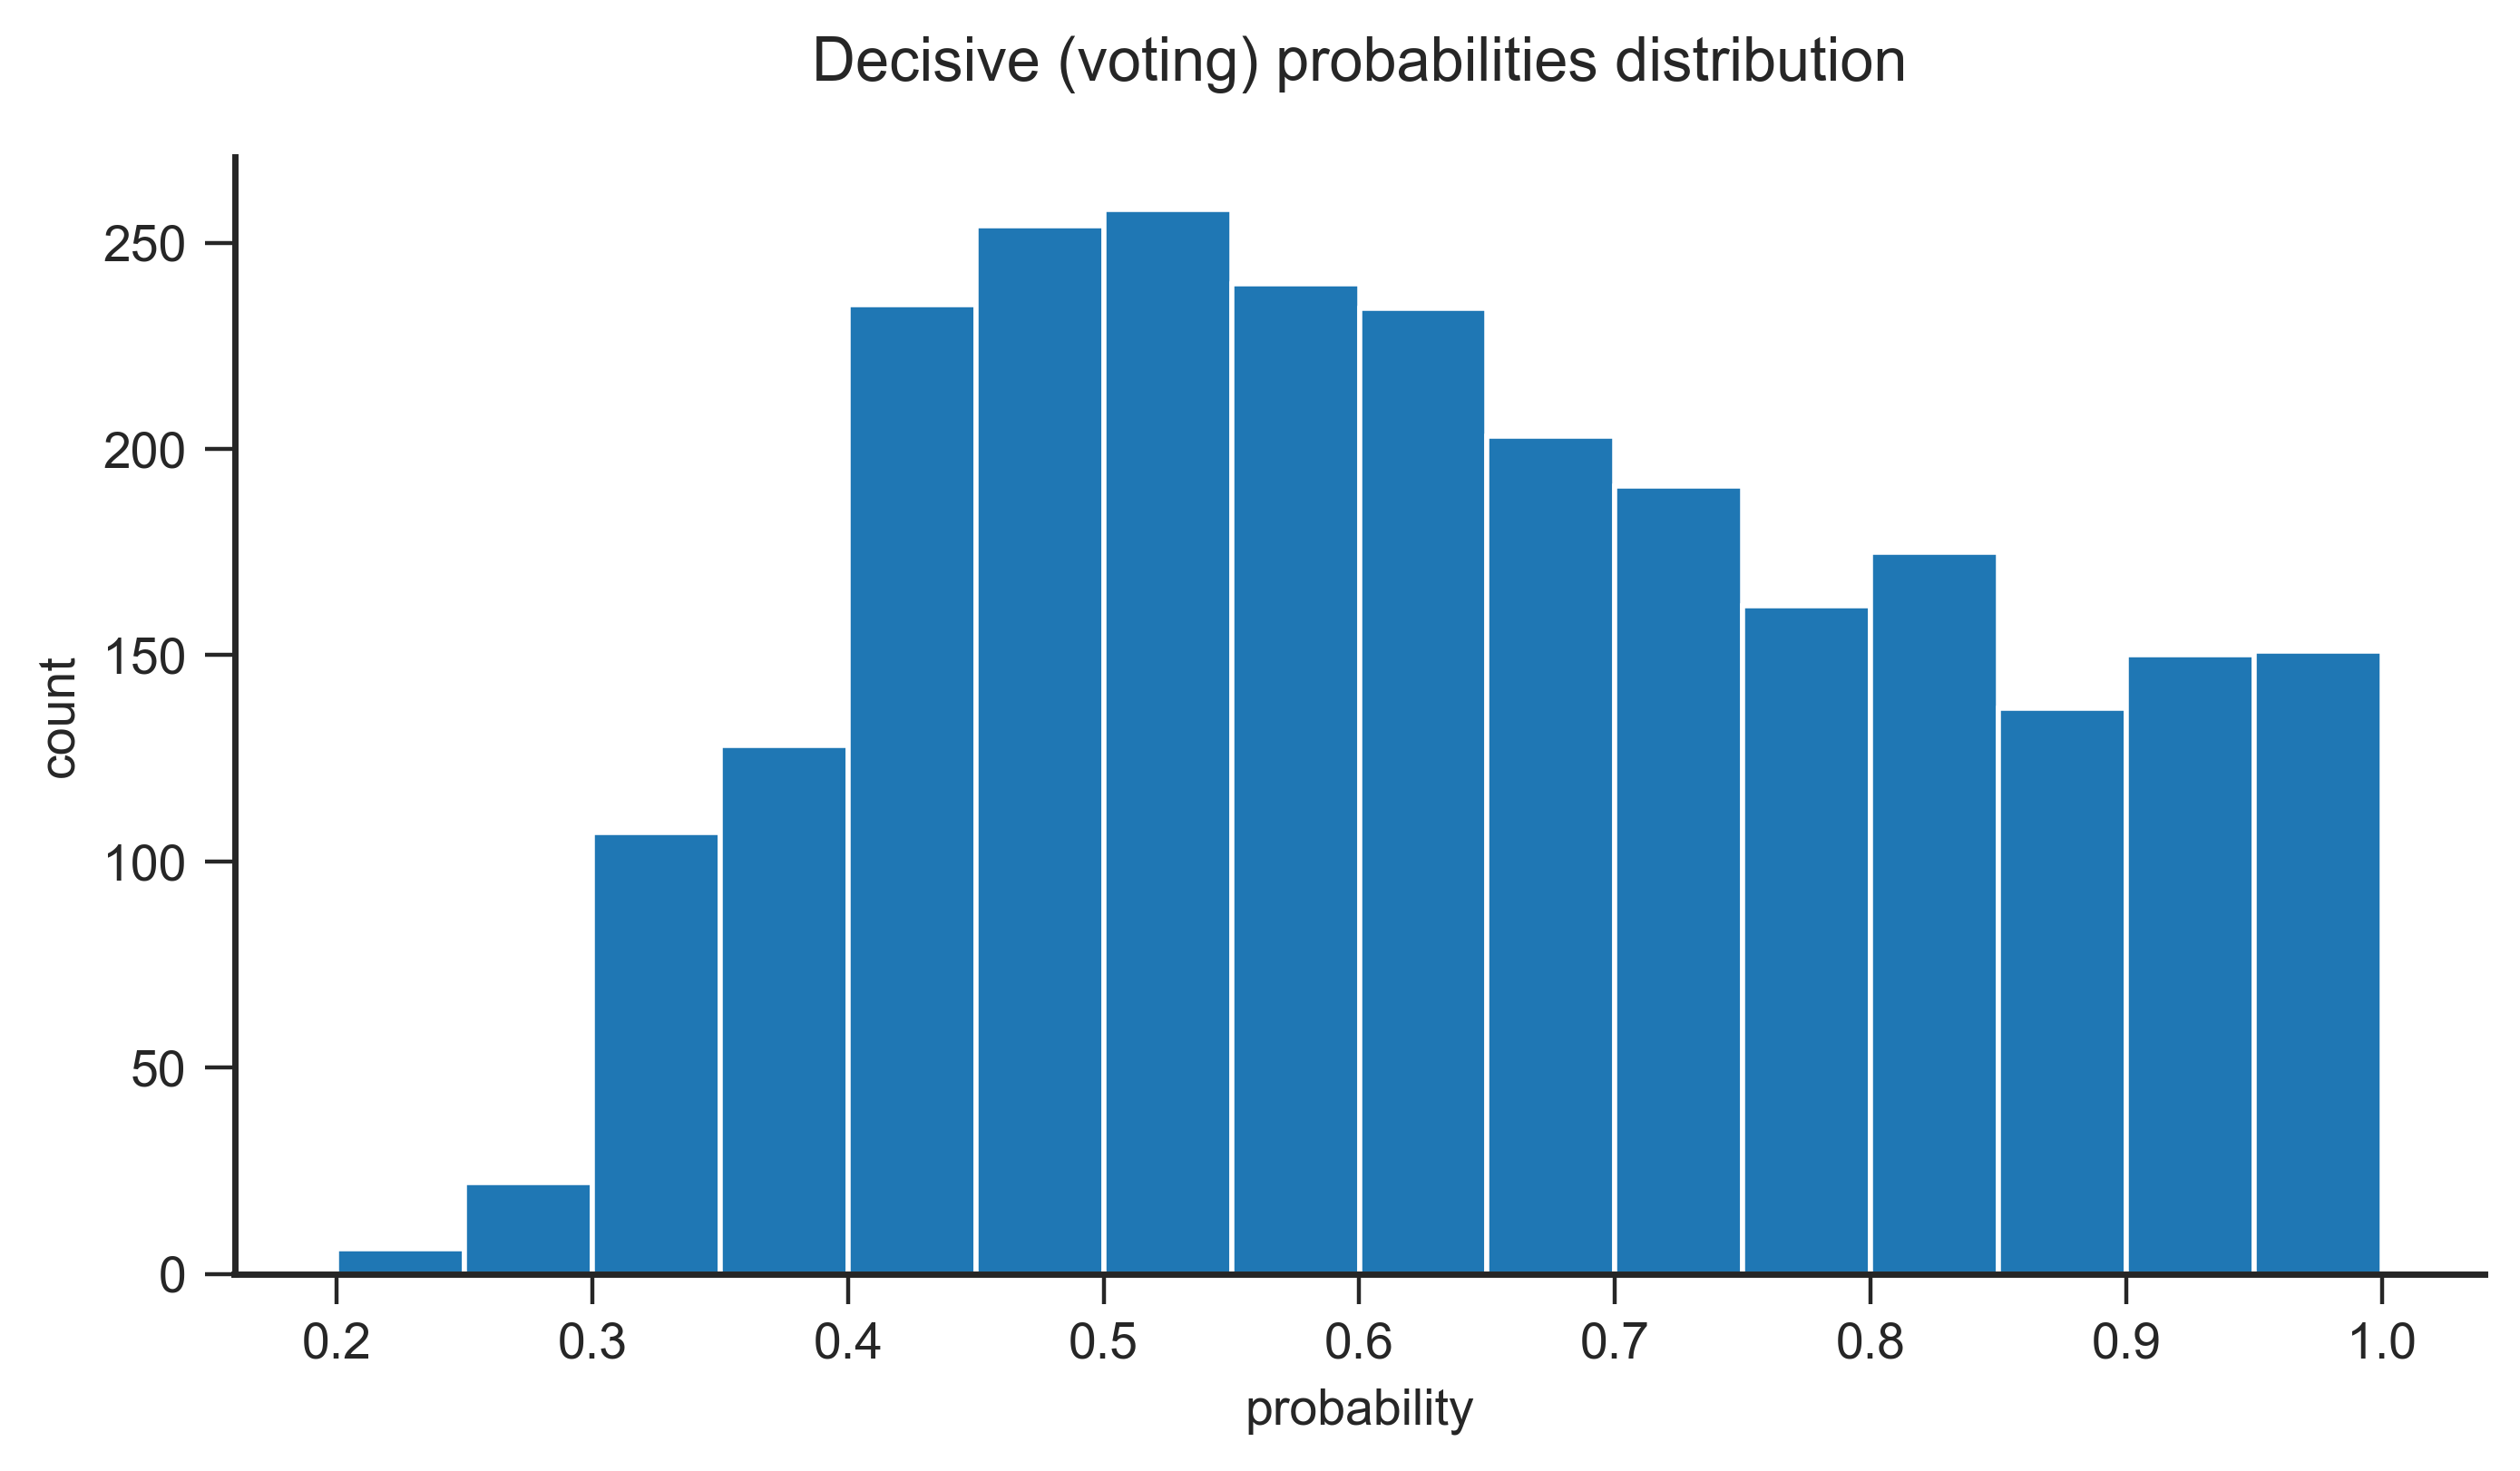

In [8]:
news_lda.plot_decisive_proba()

Тематический профиль среднего документа:

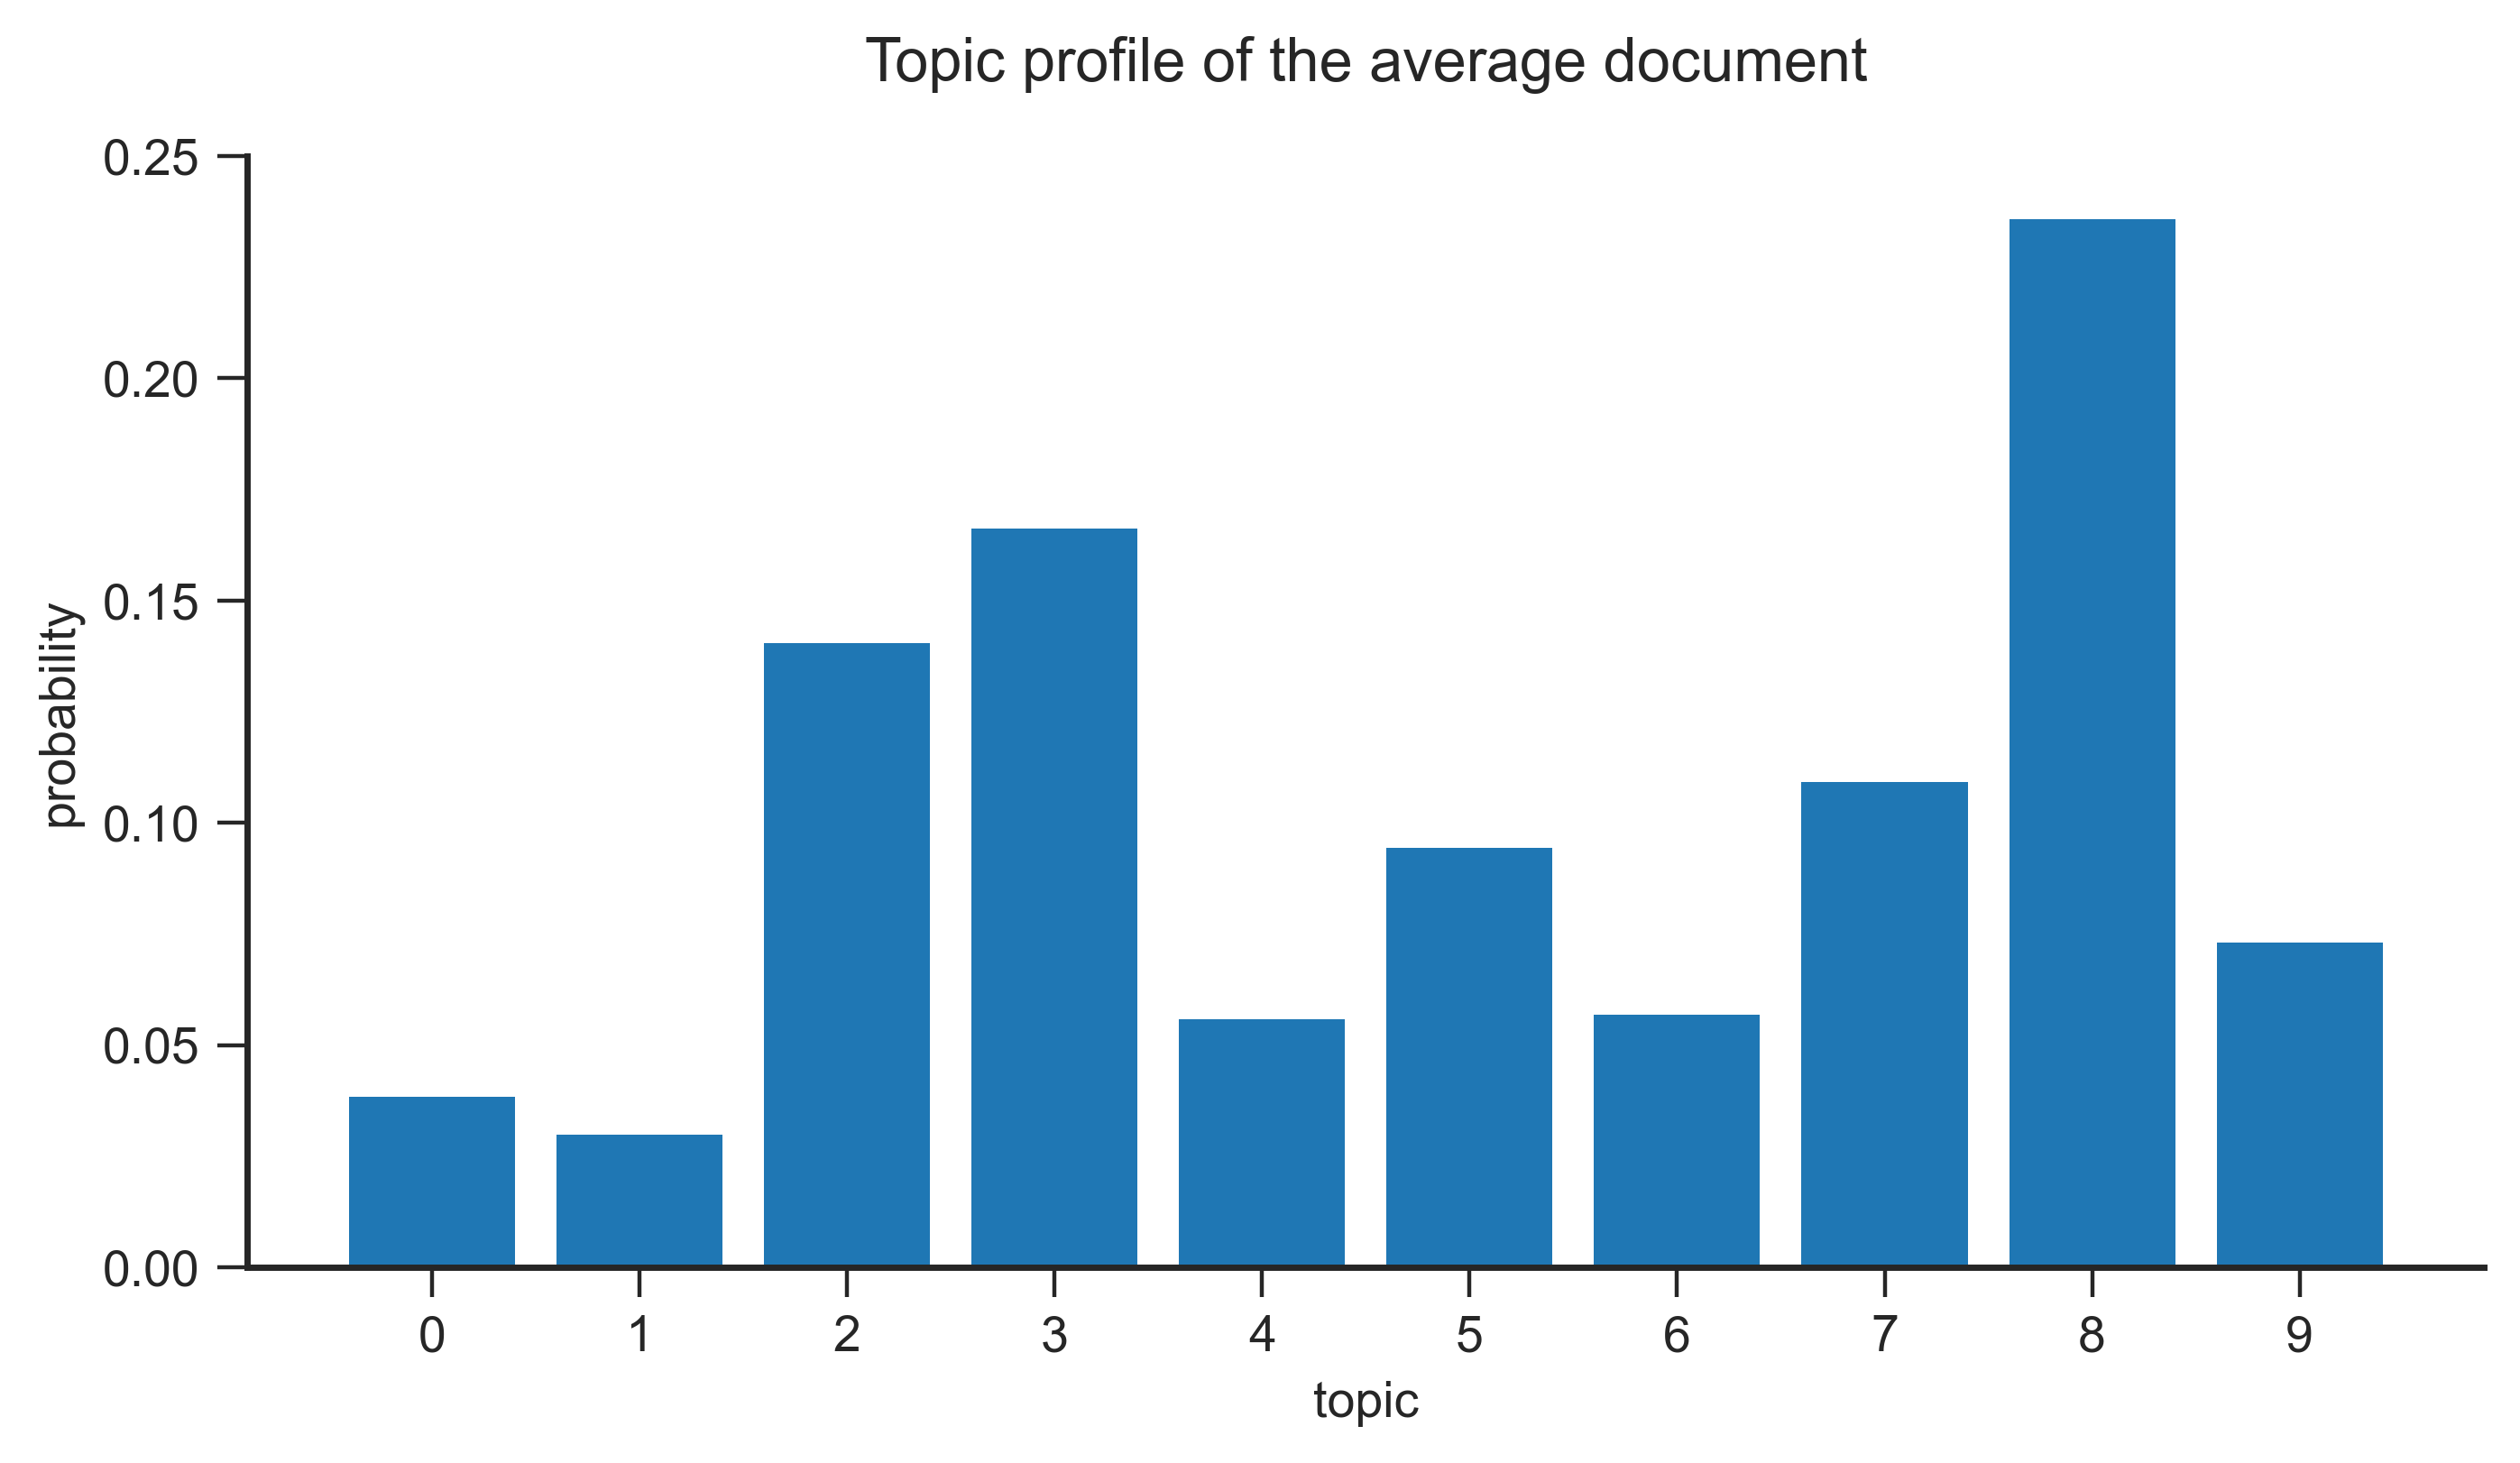

In [9]:
news_lda.plot_average_doc()

Запись результатов тематического моделирования и примененных параметров в json:

In [10]:
news_lda.to_json()